In [231]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import glob
import os
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score
from sklearn.decomposition import PCA

%matplotlib inline
%config InlineBackend.figure_formats = 'retina'
plt.rcParams['figure.figsize'] = [9, 6]
warnings.filterwarnings("ignore")

In [3]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"

In [4]:
class2ind = {}
ind2class = {}

In [5]:
for i, folder in enumerate(os.listdir(train_path)):
   ind2class[i]=folder

In [6]:
class2ind={ind2class[i]: i  for i in range(len(ind2class))}

In [7]:
class2ind

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [8]:
def get_data(path):
    data = []
    labels = []
    for folder in glob.glob(path + '/*'):
        for filename in glob.glob(folder + "/*.jpg"):
        # print(filename)
            image = cv2.imread(filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            data.append(image)
            label = filename.split('\\')[-2]
            labels.append(class2ind[label])

    return data, labels


In [9]:
train_data, train_labels = get_data(train_path)
test_data, test_labels = get_data(test_path)

# Classical approach

For classical features I will use histograms as bag of visual words.
I will create normalized histogram of the whole image, and of its parts:
* dividing the image into 9 subblocks: 50X50 pixels each
* dividing the image into 3 horizontal blocks: 50X150 pixels each
* dividing the image into 3 vertical blocks: 150X50 pixels each
and computing histograms of all of them.

I will use 16 bins. And as it will be done for 3 channels, I will get 3*(3+3+9)*16=720 features.

In [211]:
def calc_hist(img):
    '''
    Simple histogram of 16 bins for each channels
    :return: concatenated histogram of three channels, array of shape (48,1)
    '''
    r_hist = cv2.calcHist(img, [0], None, [16], [0, 256])
    g_hist = cv2.calcHist(img, [1], None, [16], [0, 256])
    b_hist = cv2.calcHist(img, [2], None, [16], [0, 256])


    #normalize histograms
    cv2.normalize(r_hist, r_hist, 0, 1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(g_hist, g_hist, 0, 1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(b_hist, b_hist, 0, 1, norm_type=cv2.NORM_MINMAX)

    #calculate histograms of 9 subblocks of 50X50 length
    # r_subblocks=[]
    # g_subblocks=[]
    # b_subblocks=[]
    # for i in range(3):
    #     for j in range(3):
    #         r_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [0], None, [16], [0, 256]))
    #         g_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [1], None, [16], [0, 256]))
    #         b_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [2], None, [16], [0, 256]))
    #
    # print(len(r_subblocks))
    # print(r_subblocks)
    # #calculate histograms of horizontal blocks (50X150)
    # r_hor = []
    # g_hor = []
    # b_hor = []
    # for i in range(3):
    #     r_hor.append(cv2.calcHist(img[i*50:(i+1)*50, :], [0], None, [16], [0, 256]))
    #     g_hor.append(cv2.calcHist(img[i*50:(i+1)*50,:], [1], None, [16], [0, 256]))
    #     b_hor.append(cv2.calcHist(img[i*50:(i+1)*50, :], [2], None, [16], [0, 256]))
    #
    # #calculate histograms of vertical blocks (50X150)
    # r_vert = []
    # g_vert = []
    # b_vert = []
    # for i in range(3):
    #     r_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [0], None, [16], [0, 256]))
    #     g_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [1], None, [16], [0, 256]))
    #     b_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [2], None, [16], [0, 256]))

    result = np.array(np.vstack([r_hist, g_hist, b_hist])).flatten()


    return result

    # return np.vstack([np.array(r_hist).flatten(),
    #                   np.array(g_hist).flatten(),
    #                   np.array(b_hist).flatten(),
    #                   np.array(r_subblocks).flatten(),
    #                   np.array(g_subblocks).flatten(),
    #                   np.array(b_subblocks).flatten(),
    #                   np.array(r_hor).flatten(),
    #                   np.array(g_hor).flatten(),
    #                   np.array(b_hor).flatten(),
    #                   np.array(r_vert).flatten(),
    #                   np.array(g_vert).flatten(),
    #                   np.array(b_vert).flatten()])

In [212]:
rgb_hist = calc_hist(train_data[1])

In [213]:
print(rgb_hist)

[0.         0.         0.         0.         0.4473684  0.2236842
 0.36842105 0.67105263 0.7236842  0.43421054 0.32894737 1.
 0.7236842  0.36842105 0.6184211  0.01315789 0.         0.
 0.         0.         0.42857143 0.20238096 0.3809524  0.6547619
 0.5595238  0.3452381  0.2857143  1.         0.5833334  0.29761904
 0.47619048 0.14285715 0.         0.         0.         0.
 0.5285714  0.17142858 0.42857143 0.85714287 0.6142857  0.51428574
 0.31428573 0.94285715 1.         0.2857143  0.31428573 0.45714286]


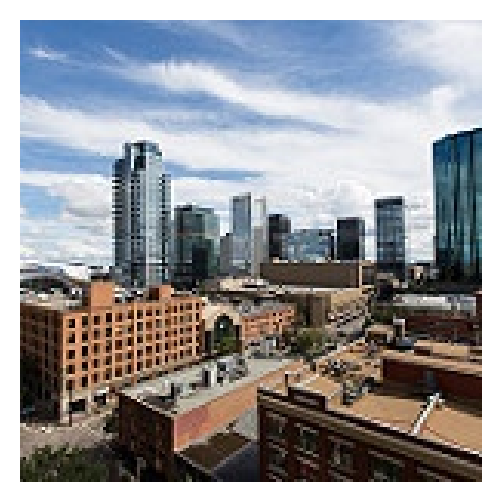

In [214]:
plt.figure(figsize=(5,3))
plt.imshow(train_data[1])
plt.axis("off")
plt.show()

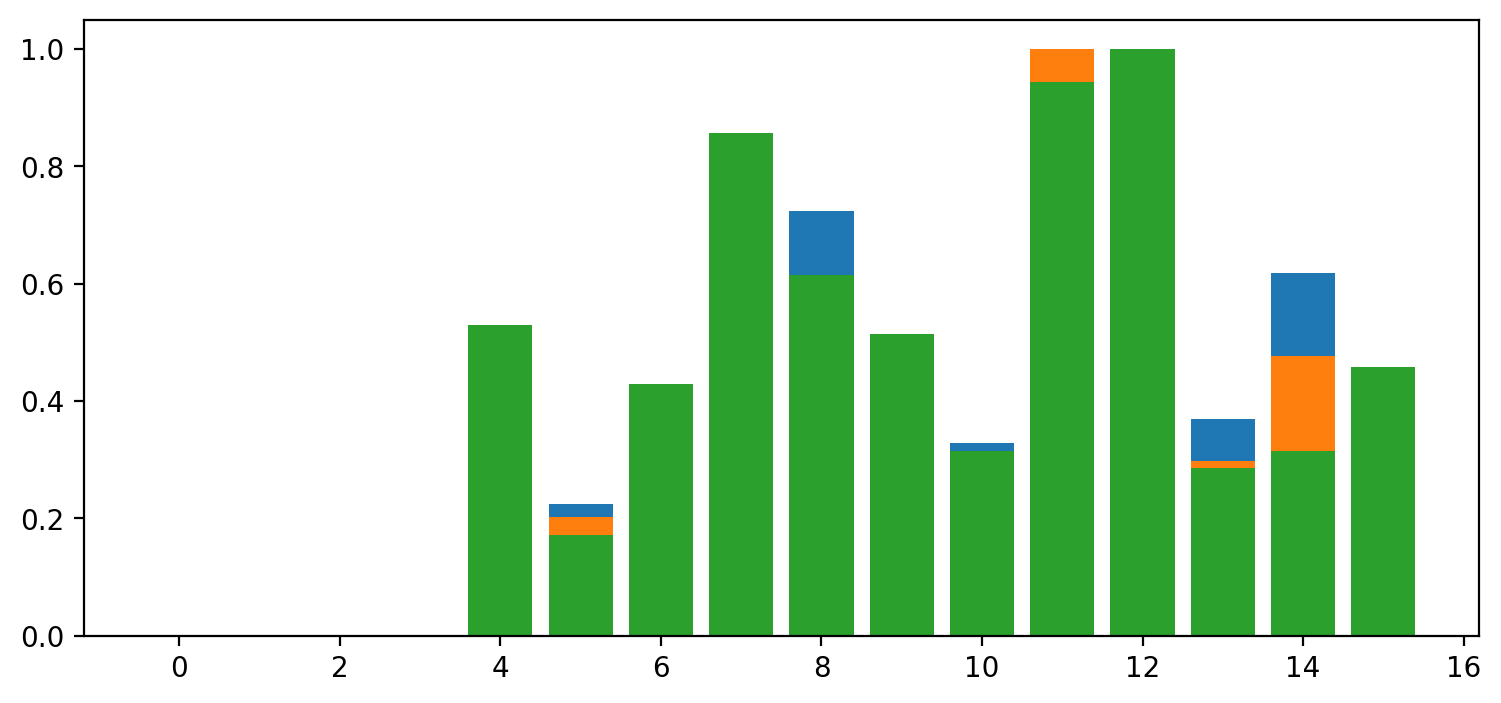

In [215]:
plt.figure(figsize=(9,4))
plt.bar(x=range(16), height = rgb_hist[:16].ravel())
plt.bar(x=range(16), height = rgb_hist[16:32].ravel())
plt.bar(x=range(16), height = rgb_hist[32:48].ravel())
plt.show()

In [216]:
train_hist = []
for image in train_data:
    train_hist.append(calc_hist(image))

In [217]:
test_hist = []
for image in test_data:
    test_hist.append(calc_hist(image))

In [218]:
X_train = pd.DataFrame(train_hist)
X_test = pd.DataFrame(test_hist)
y_train = pd.Series(train_labels)
y_test = pd.Series(test_labels)

In [219]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
1,0.000000,0.000000e+00,0.000000,0.000000,0.447368,0.223684,0.368421,0.671053,7.236842e-01,0.434211,...,0.428571,0.857143,0.614286,0.514286,3.142857e-01,0.942857,1.000000,0.285714,0.314286,0.457143
2,0.000000,0.000000e+00,0.000000,0.010309,0.000000,0.020619,0.010309,0.072165,6.701031e-01,0.515464,...,0.032609,0.097826,0.728261,0.608696,1.847826e-01,0.184783,0.847826,0.619565,1.000000,0.467391
3,0.775862,1.000000e+00,0.379310,0.224138,0.206897,0.224138,0.396552,0.586207,4.827586e-01,0.586207,...,0.543860,0.631579,0.526316,0.491228,2.456140e-01,0.719298,1.000000,0.631579,0.070175,0.000000
4,0.881890,2.992126e-01,0.244094,1.000000,0.181102,0.811024,0.125984,0.000000,0.000000e+00,0.000000,...,0.153846,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14029,0.420290,1.014493e-01,0.072464,0.202899,0.144928,0.115942,0.057971,0.000000,1.449275e-02,0.000000,...,0.095238,0.023810,0.047619,0.023810,-9.313226e-10,0.047619,0.047619,0.119048,0.071429,1.000000
14030,0.185897,1.000000e+00,0.384615,0.179487,0.217949,0.275641,0.121795,0.025641,-4.656613e-10,0.019231,...,0.191489,0.085106,0.035461,0.042553,3.546099e-02,0.042553,0.063830,0.028369,0.049645,0.000000
14031,0.279412,4.411765e-01,0.110294,0.110294,0.117647,0.110294,0.088235,0.110294,8.088236e-02,0.066176,...,0.156250,0.148438,0.125000,0.085938,7.031250e-02,0.125000,0.023438,0.000000,0.093750,1.000000
14032,1.000000,9.470199e-01,0.039735,0.000000,0.006623,0.112583,0.827815,0.046358,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.161538,6.230769e-01,0.369231,0.000000,0.000000,0.000000,0.000000


In [220]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.000000,0.000000,0.000000,0.036585,0.048780,0.097561,0.524390,0.439024,0.634146,0.707317,...,0.628205,0.384615,0.769231,0.641026,0.217949,0.205128,0.461538,0.269231,1.000000,0.756410
1,0.017857,0.044643,0.089286,0.151786,0.187500,0.133929,0.946429,0.187500,0.062500,0.053571,...,0.820513,0.188034,0.051282,0.094017,0.102564,1.000000,0.076923,0.692308,0.341880,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.016129,0.000000,0.010753,0.005376,0.000000,0.000000,0.043011,0.639785,1.000000,0.672043
3,0.010638,0.074468,0.000000,0.074468,0.095745,0.085106,0.085106,0.085106,0.159574,0.680851,...,0.079545,0.125000,0.215909,0.727273,0.704545,1.000000,0.363636,0.079545,0.318182,0.931818
4,0.000000,0.000000,1.000000,0.000000,0.033333,0.966667,0.000000,0.000000,0.106667,0.893333,...,0.000000,0.000000,0.013333,0.986667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.000000,0.000000,0.024631,0.078818,0.167488,0.157635,0.108374,0.152709,0.137931,0.147783,...,0.193548,0.112903,0.188172,0.193548,0.086022,0.086022,0.059140,0.016129,0.032258,1.000000
2996,0.046931,0.018051,0.018051,0.054152,0.061372,0.104693,0.115523,0.079422,0.028881,0.046931,...,0.072581,0.092742,0.032258,0.048387,0.032258,0.000000,0.032258,0.016129,0.000000,1.000000
2997,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.086667,...,0.000000,0.000000,0.000000,0.040000,0.593333,0.366667,0.000000,0.000000,0.000000,0.000000
2998,0.000000,0.000000,0.000000,0.000000,0.000000,0.012552,0.008368,0.025105,0.179916,0.104603,...,0.012712,0.000000,0.148305,0.059322,0.262712,1.000000,0.411017,0.000000,0.000000,0.000000


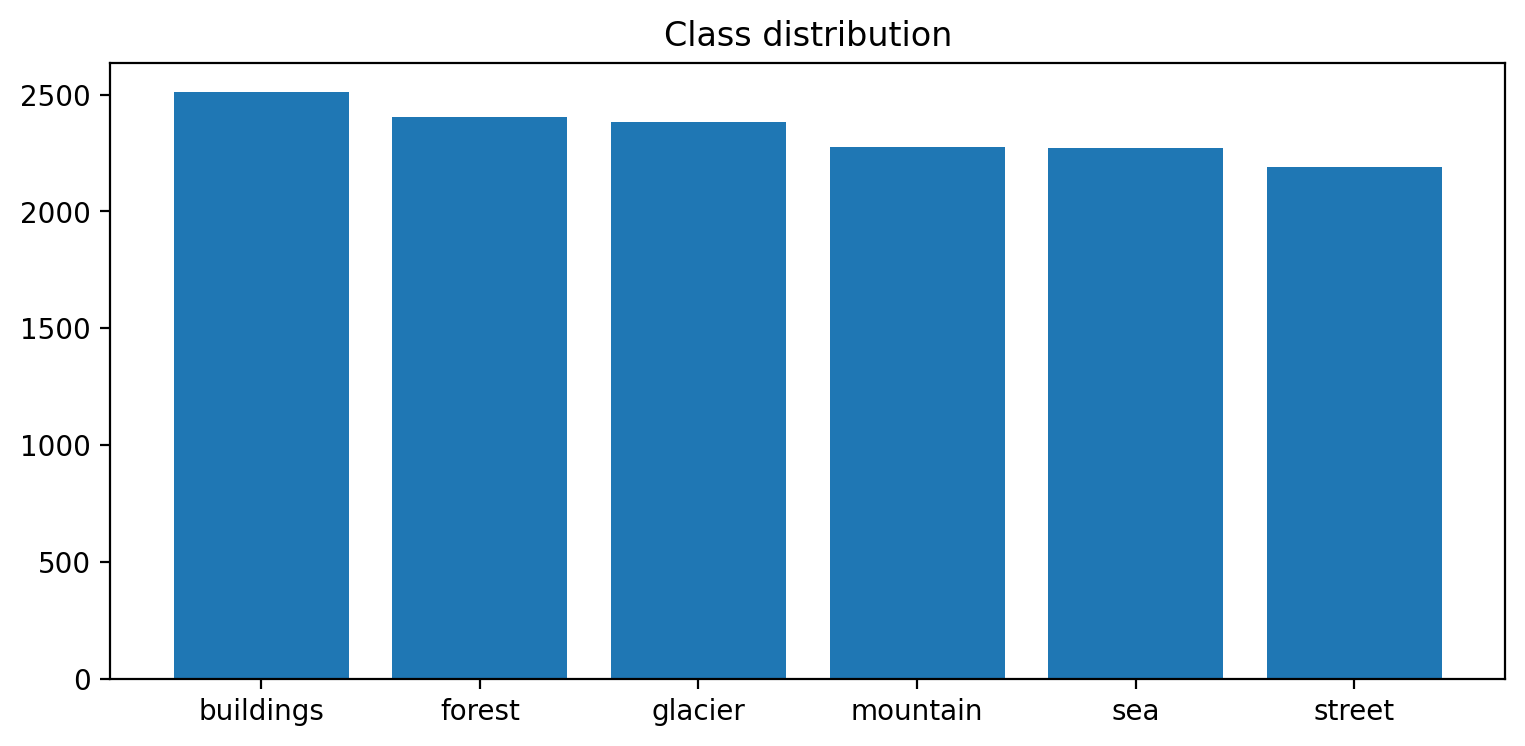

In [221]:
plt.figure(figsize=(9,4))
plt.bar(x=range(1,7), height=y_train.value_counts())
plt.xticks(range(1,7), ind2class.values())
plt.title("Class distribution")
plt.show()

In [222]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42, stratify=train_labels)

In [223]:
X_train.shape

(11227, 48)

In [224]:
X_val.shape

(2807, 48)

In [225]:
X_test.shape

(3000, 48)

## Logistic regression model

In [206]:
lr = LogisticRegression()

In [207]:
lr.fit(X_train, y_train)

LogisticRegression()

In [208]:
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)

In [209]:
y_pred

array([3, 3, 3, ..., 4, 3, 1], dtype=int64)

In [210]:
print(f"Accuracy {accuracy_score(y_test, y_pred): .4f}")

Accuracy  0.3097


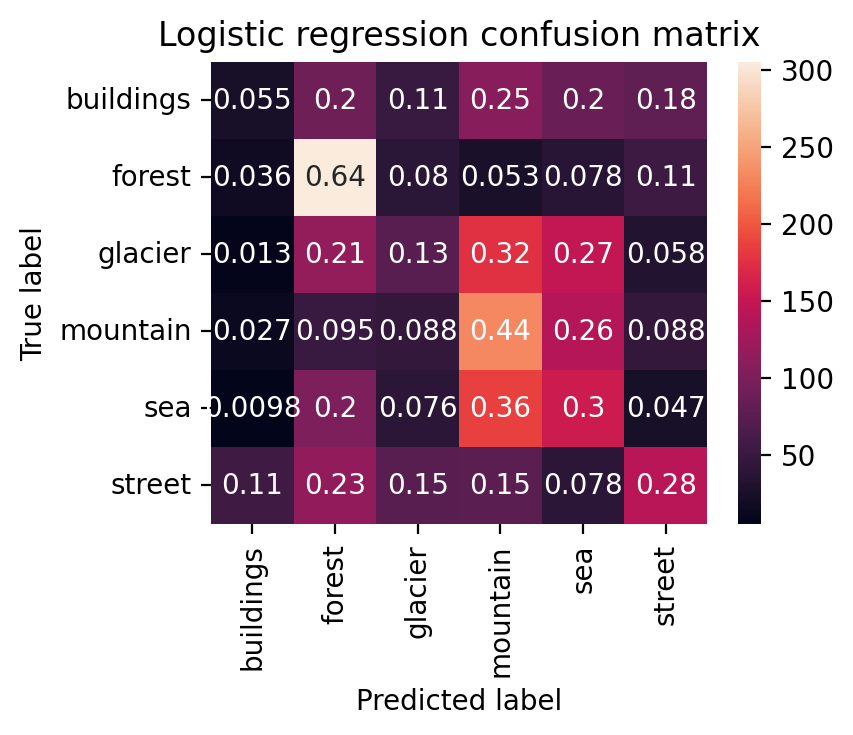

In [227]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3));
sns.heatmap(conf,
            annot=conf/conf.astype(np.float).sum(axis=1, keepdims=True), #normalized by true class sizes
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

In [228]:
print(classification_report(y_test, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.20      0.05      0.09       437
      forest       0.39      0.64      0.49       474
     glacier       0.23      0.13      0.17       553
    mountain       0.29      0.44      0.35       525
         sea       0.26      0.30      0.28       510
      street       0.38      0.28      0.32       501

    accuracy                           0.31      3000
   macro avg       0.29      0.31      0.28      3000
weighted avg       0.29      0.31      0.28      3000



<AxesSubplot: >

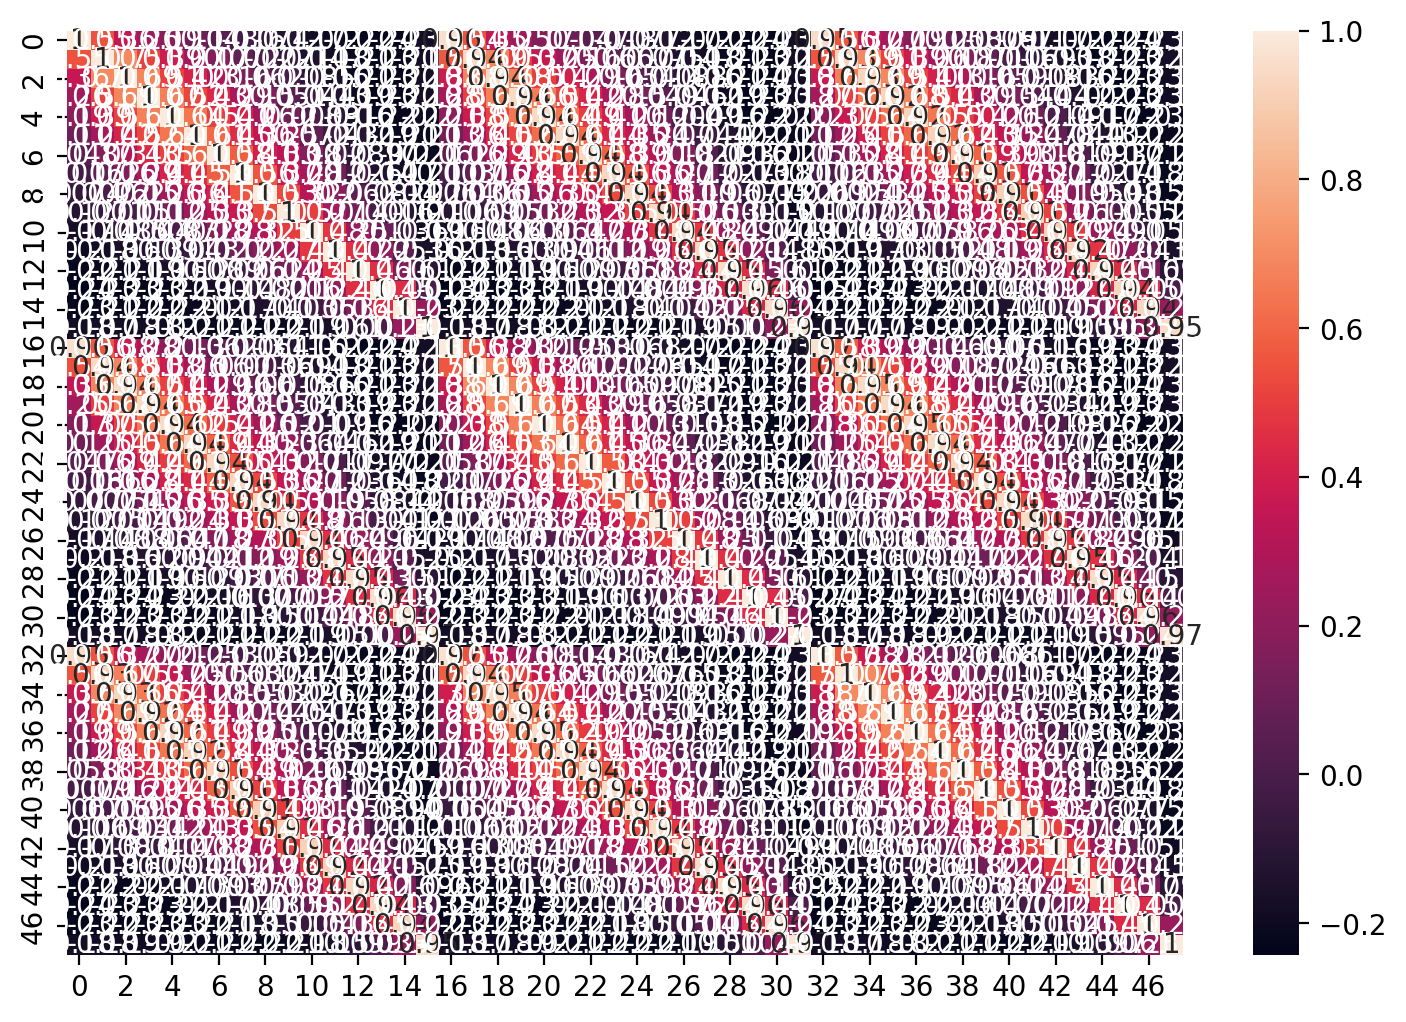

In [230]:
corr = X_train.corr()
sns.heatmap(corr, annot=True)

Features are highly correlated. Let's do PCA.

In [233]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)

In [235]:
X_train_pca.shape

(11227, 15)

In [238]:
X_test_pca = pca.transform(X_test)

### Tuning hyperparameters

In [240]:
lr.fit(X_train_pca, y_train)

LogisticRegression()

In [241]:
y_pred = lr.predict(X_test_pca)
y_prob = lr.predict_proba(X_test_pca)

In [242]:
print(f"Accuracy {accuracy_score(y_test, y_pred): .4f}")

Accuracy  0.3470


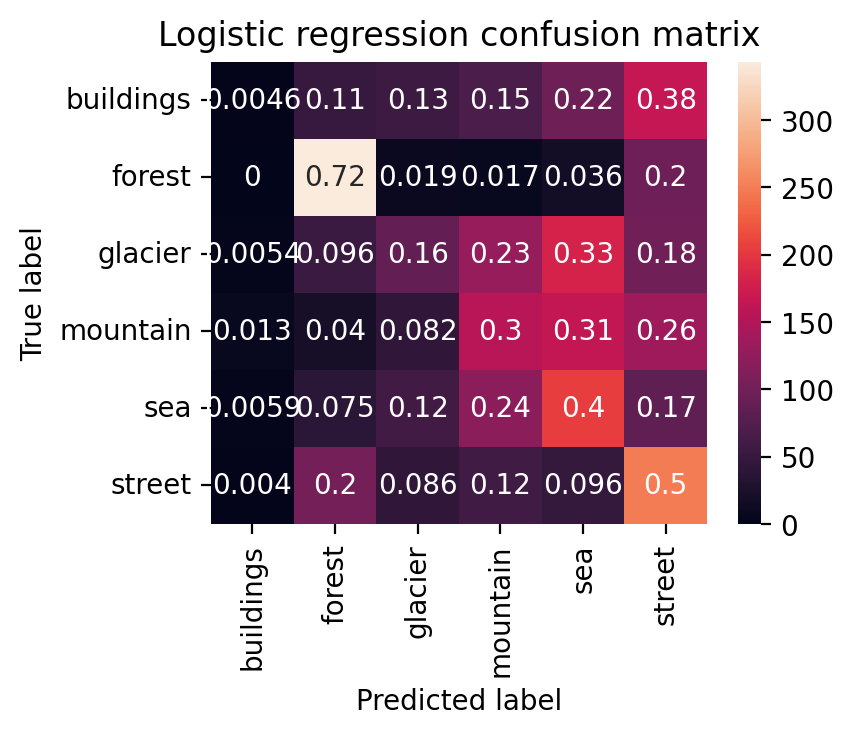

In [243]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3));
sns.heatmap(conf,
            annot=conf/conf.astype(np.float).sum(axis=1, keepdims=True), #normalized by true class sizes
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

# NN approach

### Create custom dataset of images

In [19]:
class ImageDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.img_data = data
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_data[idx]
        label = self.img_labels[idx]
        if self.transform:
            image =self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [20]:
train_dataset = ImageDataset(train_data, train_labels)

In [21]:
train_dataset

In [22]:
image, label = train_dataset[14000]

In [23]:
print(image)

[[[251 255 246]
  [221 225 219]
  [170 174 175]
  ...
  [167 150 117]
  [201 177 141]
  [167 142 102]]

 [[243 249 238]
  [243 247 241]
  [187 189 190]
  ...
  [135 117  86]
  [181 159 123]
  [215 192 154]]

 [[237 240 231]
  [236 240 235]
  [123 125 126]
  ...
  [200 181 154]
  [233 212 180]
  [231 209 174]]

 ...

 [[104  98 103]
  [105  99 104]
  [107 102 104]
  ...
  [ 72  64  64]
  [ 49  44  43]
  [ 55  50  49]]

 [[107 101 106]
  [107 101 106]
  [109 104 106]
  ...
  [ 65  60  59]
  [ 66  61  60]
  [ 39  34  33]]

 [[113 107 112]
  [111 105 110]
  [109 104 106]
  ...
  [ 66  61  60]
  [ 74  69  68]
  [ 34  29  28]]]


In [24]:
image.dtype

dtype('uint8')

In [25]:
def visualise_images(dataset):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    idx = np.random.randint(0, len(dataset), 10)
    for i, index in enumerate(idx):
        axs[i//5, i%5].imshow(dataset[index][0])
        axs[i//5, i%5].axis("off")
        title = ind2class[dataset[index][1]]
        axs[i//5, i%5].set_title(f"Class {title}")

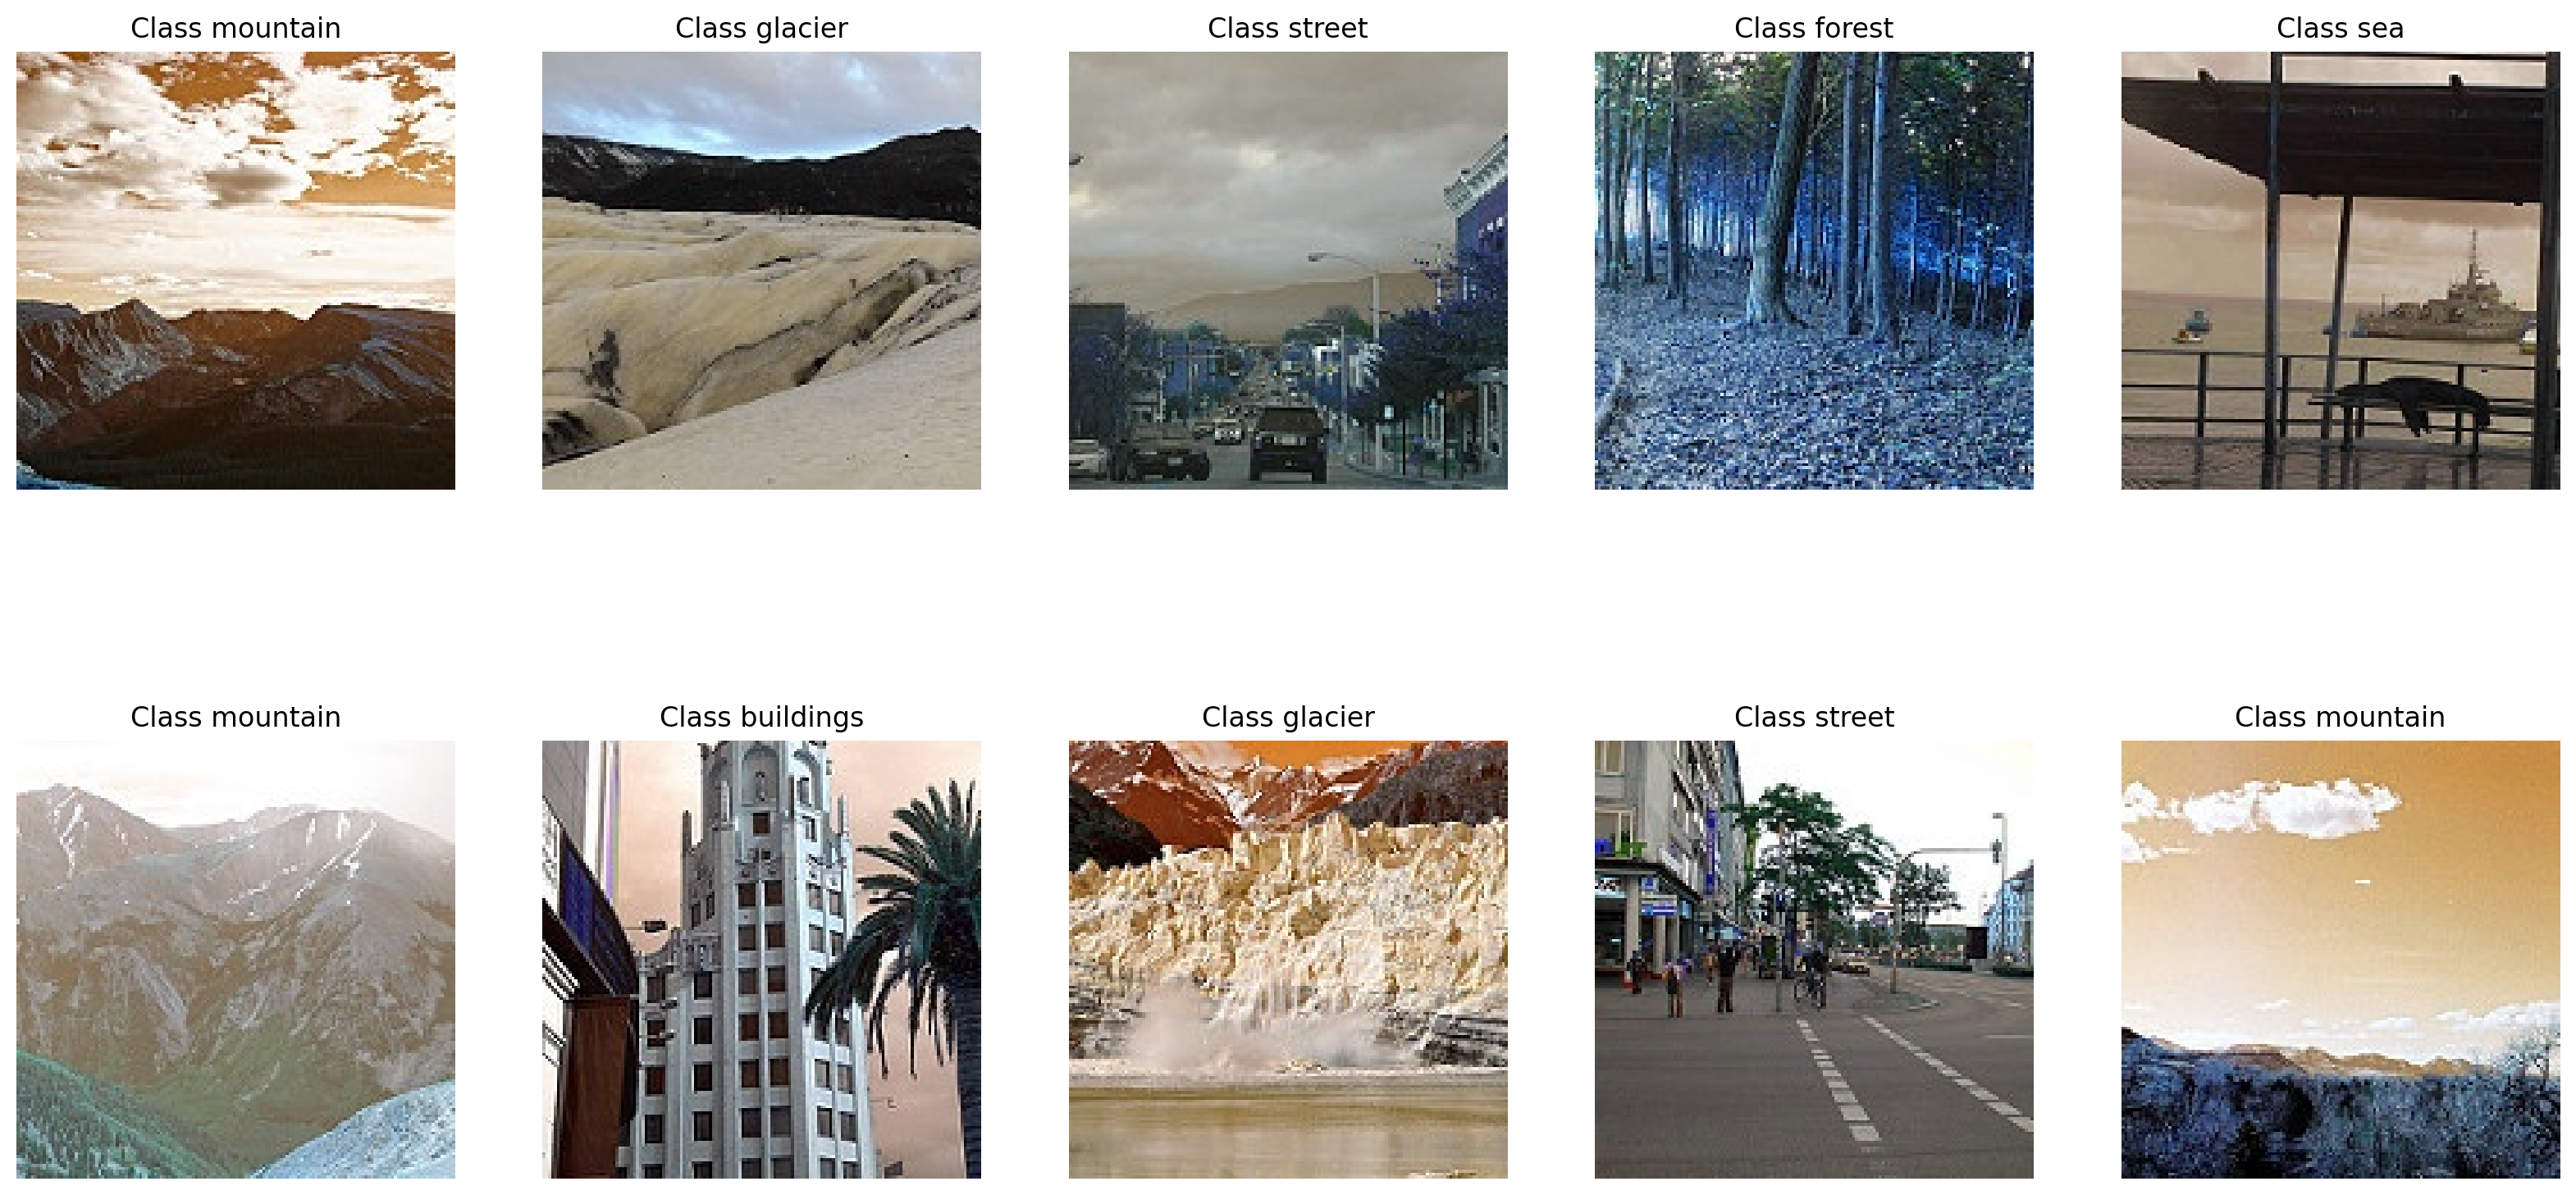

In [26]:
visualise_images(train_dataset)

In [97]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.CenterCrop((150, 150)),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]
)

In [104]:
train_dataset = ImageDataset(train_data, train_labels, transform=transform)
test_dataset = ImageDataset(test_data, test_labels, transform=transform)

In [103]:
train_dataset[0][0].shape

torch.Size([3, 150, 150])

### Create dataloaders

In [107]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [108]:
for image, label in train_loader:
    print(image)
    print(label)
    break

tensor([[[[-0.6281, -0.5767, -0.5424,  ..., -0.3541, -0.3712, -0.3883],
          [-0.4739, -0.4739, -0.4911,  ..., -0.3369, -0.3712, -0.4054],
          [-0.5082, -0.4739, -0.4739,  ..., -0.3712, -0.4226, -0.4568],
          ...,
          [-2.1179, -2.1179, -2.1008,  ...,  0.2796,  0.4679,  0.8276],
          [-2.1179, -2.1179, -2.1008,  ...,  0.5878,  0.8618,  0.5536],
          [-2.1179, -2.1179, -2.1008,  ...,  0.7248,  1.2557,  0.6221]],

         [[ 0.1877,  0.2402,  0.2752,  ...,  0.3277,  0.3102,  0.2927],
          [ 0.3452,  0.3452,  0.3277,  ...,  0.3452,  0.3102,  0.2752],
          [ 0.3627,  0.3978,  0.3978,  ...,  0.3102,  0.2577,  0.2227],
          ...,
          [-1.8782, -1.9132, -1.9657,  ..., -0.0049,  0.1877,  0.5553],
          [-1.8957, -1.9307, -1.9657,  ...,  0.2752,  0.5903,  0.2752],
          [-1.9132, -1.9482, -1.9657,  ...,  0.4153,  0.9930,  0.3452]],

         [[ 1.4722,  1.5245,  1.5245,  ...,  1.3677,  1.3851,  1.3677],
          [ 1.5942,  1.5942,  